# Retrain RF on new data (experiment w/ weights)

In [112]:
library(dplyr)
library(data.table)
library(partykit)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(rPython)
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)
library(tidyverse)


getwd()

[1] "/home/jupyter/local/Domains_202003/scripts/phaseII_gcloudaccess"

In [113]:
ls()

[1] "apply_standard_adjustments"        "auc_ranger_03_expiry"             
 [3] "auc_seg_glm_expiry_exptest"        "basic_prep_domain_data"           
 [5] "build_model_first_renewal"         "build_model_second_renewal"       
 [7] "calc_auc"                          "change.colnames"                  
 [9] "chart_lift"                        "CM_thresh_test"                   
[11] "cm5"                               "cm6"                              
[13] "df5"                               "df6"                              
[15] "expiry_test_df_1"                  "expiry_test_df_sub"               
[17] "expiry_test_prepped_2"             "expiry_test_prepped_2_1"          
[19] "expiry_train_df_1"                 "expiry_train_df_sub"              
[21] "expiry_train_prepped_2"            "expiry_train_prepped_2_1"         
[23] "fig"                               "first_renewal_model_expiry_train" 
[25] "gains_plot_ranger_03_expiry"       "gains_plot_seg_glm_expiry_exptest"
[27] "get_cluster_data"                  "get_cluster_large"                
[29] "get_df_npv"                        "get_domain_npv"                   
[31] "get_domain_type"                   "get_pattern_score"                
[33] "get_renewal_status"                "hyper_grid_comp"                  
[35] "intersect2"                        "lift_df_ranger_03_expiry"         
[37] "lift_df_seg_glm_expiry_exptest"    "lift_newdata_df"                  
[39] "list_predict_first_renewal"        "list_predict_second_renewal"      
[41] "mass_build_model_first_renewal"    "mass_build_model_second_renewal"  
[43] "mass_predict_first_renewal"        "mass_predict_second_renewal"      
[45] "mass_prep_data"                    "na.zero"                          
[47] "newreg_data_prep"                  "newreg_data_rename"               
[49] "newreg_data_select"                "perf_newdata_df"                  
[51] "plot_gains"                        "plot_multigains"                  
[53] "plot_multigains_03_summ4"          "predict_first_renewal"            
[55] "predict_second_renewal"            "prep_domain_data"                 
[57] "ranger_03_expiry"                  "ranger_03_pred_df_expiry"         
[59] "ranger_predict_03_expiry"          "results_df"                       
[61] "results5"                          "results6"                         
[63] "rf"                                "rf_weighted"                      
[65] "s"                                 "save_object"                      
[67] "seg_glm_expiry_exptest"            "seg_glm_expiry_exptest_pred_df"   
[69] "test_1"                            "test_2"                           
[71] "test_21"                           "test_22"                          
[73] "test_23"                           "test_3"                           
[75] "test_4"                            "tr"                               
[77] "tr_idxs"                           "ts"                               
[79] "ts_idxs"                           "unzip.file"

In [114]:

source('../orig/functions.R')

source('../orig/functions_models.R')

source('functions_eval.R')

source('load_prep_data_expiry.R')


# Load data
now in load_prep... function above

In [13]:
# FIRST STAGE RENEWALS ONLY

# LOAD list of dfs
# system("gsutil cp gs://data_outputt/output/expiry_train_prepped_2 /home/jupyter/local/Domains_202003/data/expiry_train_prepped_2")
# expiry_train_prepped_2 <- readRDS("/home/jupyter/local/Domains_202003/data/expiry_train_prepped_1list")

# system("gsutil cp gs://data_outputt/output/expiry_test_prepped_2 /home/jupyter/local/Domains_202003/data/expiry_test_prepped_2")
# expiry_test_prepped_2 <- readRDS("/home/jupyter/local/Domains_202003/data/expiry_test_prepped_1list")

# REMOVE empty list items from each list (does not change the dim of rbound list)
# expiry_train_prepped_2_1 <- expiry_train_prepped_2[sapply(expiry_train_prepped_2, function(x) dim(x)[1]) > 0]
# expiry_test_prepped_2_1 <- expiry_test_prepped_2[sapply(expiry_test_prepped_2, function(x) dim(x)[1]) > 0]

# RBIND list of dfs
# expiry_train_df_1 <- rbindlist(expiry_train_prepped_2_1, fill=TRUE)
# expiry_test_df_1 <- rbindlist(expiry_test_prepped_2_1, fill=TRUE)

In [65]:
# renewals at all stages

# # system("gsutil cp gs://data_outputt/output/expiry_train_prepped_2 /home/jupyter/local/Domains_202003/data/expiry_train_prepped_2")
# expiry_train_prepped_2 <- readRDS("/home/jupyter/local/Domains_202003/data/expiry_train_prepped_2")

# # system("gsutil cp gs://data_outputt/output/expiry_test_prepped_2 /home/jupyter/local/Domains_202003/data/expiry_test_prepped_2")
# expiry_test_prepped_2 <- readRDS("/home/jupyter/local/Domains_202003/data/expiry_test_prepped_2")


# expiry_train_df <- rbindlist(expiry_train_prepped_2, fill=TRUE)
# expiry_test_df <- rbindlist(expiry_test_prepped_2, fill=TRUE)

In [95]:
# was 139436639, 34859139... should be 1188250, 296797

dim(expiry_train_df_1)
dim(expiry_test_df_1)

[1] 1188250      39

[1] 296797     39

In [145]:
# OR MANUAL way to exclude subsequent renewals from list of df's

# expiry_train_prepped_2_1 <- lapply(expiry_train_prepped_2, 
#                                       function(x)x[x[[1]]=='FirstTime'])
# expiry_test_prepped_2_1 <- lapply(expiry_test_prepped_2, 
#                                       function(x)x[x[[1]]=='FirstTime'])

# expiry_train_prepped_2_1 <- expiry_train_prepped_2_1[sapply(expiry_train_prepped_2_1, function(x) dim(x)[1]) > 0]
# expiry_test_prepped_2_1 <- expiry_test_prepped_2_1[sapply(expiry_test_prepped_2_1, function(x) dim(x)[1]) > 0]

# expiry_train_df_1 <- rbindlist(expiry_train_prepped_2_1, fill=TRUE)
# expiry_test_df_1 <- rbindlist(expiry_test_prepped_2_1, fill=TRUE)

# dim(expiry_train_df_1)
# dim(expiry_test_df_1)

# Assess Ranger Hyper Param Tuning Results

In [12]:
results_df <- read_csv("../../data/hyper_grid_expiry.log", col_names=FALSE)[c(2:6)]
names(results_df) <- c("mtry","sample.fraction","replace","OOB_RMSE","timestamp")
head(results_df)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_logical(),
  X5 = col_double(),
  X6 = col_character()
)



mtry,sample.fraction,replace,OOB_RMSE,timestamp
<dbl>,<dbl>,<lgl>,<dbl>,<chr>
1,0.5,TRUE,0.2605507,2020-07-18 16:18:59 PDT
2,0.5,TRUE,0.2481628,2020-07-18 16:20:23 PDT
3,0.5,TRUE,0.2463284,2020-07-18 16:22:17 PDT
4,0.5,TRUE,0.2462503,2020-07-18 16:24:35 PDT
5,0.5,TRUE,0.2466001,2020-07-18 16:26:57 PDT
6,0.5,TRUE,0.2471266,2020-07-18 16:29:38 PDT


In [15]:
results_df <- as.data.table(results_df)
results_df[ , .SD[which.min(OOB_RMSE)], by = replace]

replace,mtry,sample.fraction,OOB_RMSE,timestamp
<lgl>,<dbl>,<dbl>,<dbl>,<chr>
TRUE,3,0.9,0.2459659,2020-07-18 18:15:07 PDT
FALSE,3,0.8,0.2458980,2020-07-18 20:59:25 PDT


In [22]:
# hyper_grid_comp = subset(results_df,replace=='FALSE')
# s = interp(hyper_grid_comp$mtry,
#            hyper_grid_comp$sample.fraction,
#            hyper_grid_comp$OOB_RMSE)

# fig <- plot_ly(x = s$x, # mtry
#                y = s$y, # sample_size
#                z = s$z) %>% add_surface()

# fig

In [19]:
head(hyper_grid_comp)

mtry,sample.fraction,replace,OOB_RMSE,timestamp
<dbl>,<dbl>,<lgl>,<dbl>,<chr>
1,0.5,TRUE,0.2605507,2020-07-18 16:18:59 PDT
2,0.5,TRUE,0.2481628,2020-07-18 16:20:23 PDT
3,0.5,TRUE,0.2463284,2020-07-18 16:22:17 PDT
4,0.5,TRUE,0.2462503,2020-07-18 16:24:35 PDT
5,0.5,TRUE,0.2466001,2020-07-18 16:26:57 PDT
6,0.5,TRUE,0.2471266,2020-07-18 16:29:38 PDT


# Retrain Ranger_03

## per the same definitions as in dtree_xl.ipynb, but added reg_arpt as a predictor

In [23]:
# expiry_train_df_sub <- subset(expiry_train_df_1, 
#        select = c(renewal_status, tld, registrar, reseller, reseller_country, region, reg_period, 
#                   sld_type, sld_length, day_domains, gibb_score, pattern_domain_count,reg_arpt) )
# head(expiry_train_df_sub)

In [24]:
# # expiry_test_df_1 <- expiry_test_df %>% filter(renewal_type == 'FirstTime')
# expiry_test_df_sub <- subset(expiry_test_df_1, 
#        select = c(renewal_status, tld, registrar, reseller, reseller_country, region, reg_period, 
#                   sld_type, sld_length, day_domains, gibb_score, pattern_domain_count,reg_arpt) )
# head(expiry_test_df_sub)

In [115]:
# model fitting: 952.151 sec elapsed (model fitting: 160sec (sole operation) OR 334.385 sec elapsed on 16 core)
# model saving: 163.762 sec elapsed ( 67.825 sec on 16 core)

# 1000 trees model fitting: 299.005 sec elapsed ( 470.493 sec elapsed with non default params)


# tic("model fitting")

ranger_03_expiry <- ranger(
    formula         = renewal_status ~ ., 
    data            = expiry_train_df_sub, 
    importance = 'impurity', 
    num.trees       = 1000,
    probability = TRUE,
    mtry            = 3,
    min.node.size   = 10,
    replace = FALSE,
    sample.fraction = .8,
    seed            = 123
)

# toc()

# tic("model saving")
# save(ranger_03_expiry, file="../../data/output/ranger_03_expiry")
# toc()

Growing trees.. Progress: 14%. Estimated remaining time: 3 minutes, 2 seconds.
Growing trees.. Progress: 30%. Estimated remaining time: 2 minutes, 28 seconds.
Growing trees.. Progress: 45%. Estimated remaining time: 1 minute, 53 seconds.
Growing trees.. Progress: 60%. Estimated remaining time: 1 minute, 21 seconds.
Growing trees.. Progress: 76%. Estimated remaining time: 50 seconds.
Growing trees.. Progress: 90%. Estimated remaining time: 19 seconds.


## test ranger_03 on expiry_test

In [116]:

# # model predict: 65.851 sec elapsed (18sec on 16 core)
# # eval saving: 0.132 sec elapsed

# # tic("model predict")
# ranger_predict_03_expiry <- predict(ranger_03_expiry, 
#                           data = expiry_test_df_sub,
#                           type="response")$predictions
# toc()

# tic("eval saving")

# ranger_predict_03_expiry <- as.data.frame(ranger_predict_03_expiry)$Renewed

# # save(ranger_predict_03_expiry, 
# #      file="../../data/output/ranger_predict_03_expiry")
# toc()


model fitting: 1234.831 sec elapsed


In [117]:
# ranger_03_pred_df_expiry = data.frame("actual" = expiry_test_df_sub$renewal_status,
#           "predicted" = ranger_predict_03_expiry)

# # lift df: 23.675 sec elapsed
# # gains plot: 0.046 sec elapsed
# # auc: 0.007 sec elapsed
# tic("lift df")
# lift_df_ranger_03_expiry <- chart_lift(pred_df = ranger_03_pred_df_expiry,
#                         dep_var = "actual",
#                         pred_var = "predicted")

# toc()
# tic("gains plot")
# gains_plot_ranger_03_expiry <- plot_gains (lift_df_ranger_03_expiry) 

# toc()
# tic("auc")
# auc_ranger_03_expiry <- calc_auc(lift_df_ranger_03_expiry)
# toc()


# # saveRDS(lift_df_ranger_03_expiry, file.path('../../data/output/',"lift_df_ranger_03_expiry"))


lift df: 1.015 sec elapsed
gains plot: 0.015 sec elapsed
auc: 0.005 sec elapsed


In [123]:
load("../../data/output/ranger_03_expiry")
load("../../data/output/ranger_predict_03_expiry")
lift_df_ranger_03_expiry <- readRDS('../../data/output/lift_df_ranger_03_expiry')

In [124]:
lift_df_ranger_03_expiry

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,11192,0.4121525,4.121525
0.2,15918,0.5861904,2.930952
0.3,18871,0.6949365,2.316455
0.4,21434,0.7893206,1.973301
0.5,23305,0.8582213,1.716443
0.6,24687,0.9091143,1.515191
0.7,25739,0.9478549,1.354078
0.8,26673,0.9822500,1.227813
0.9,27076,0.9970908,1.107879


[1] 0.7679599

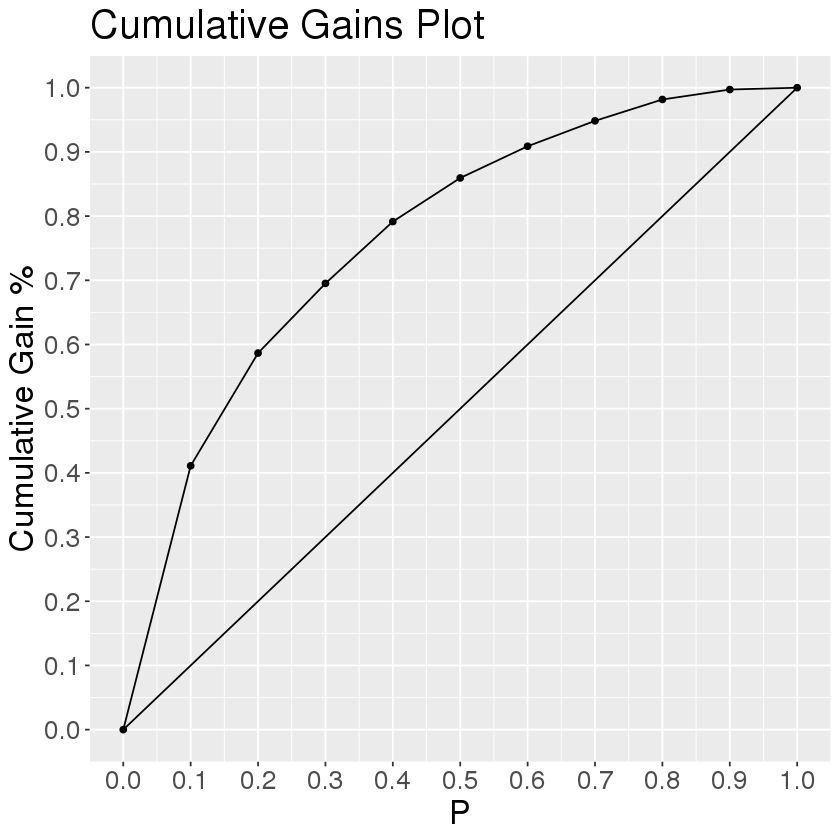

In [125]:
auc_ranger_03_expiry
gains_plot_ranger_03_expiry

In [127]:
# system("gsutil cp /home/jupyter/local/Domains_202003/data/output/* gs://data_outputt/output/")
# system("mv /home/jupyter/local/Domains_202003/data/output/* /home/jupyter/local/Domains_202003/data/")

In [121]:
as.data.frame(sort(ranger_03_expiry$variable.importance,decreasing=TRUE))

,"sort(ranger_03_expiry$variable.importance, decreasing = TRUE)"
,<dbl>
log_reg_arpt,14955.6704
day_domains,13087.5965
gibb_score,9873.4590
registrar,6342.0595
sld_length,4931.9636
reseller_country,4343.9718
tld,3364.0859
pattern_domain_count,2707.0927
sld_type,1823.7637


lift_df_ranger3

# how well does seg_glm perf when trained on this data?

## need to retrain model on expiry_train_prepped_2 (list of dfs)


In [90]:
table(expiry_train_df_1$renewal_type)


FirstTime 
  1188250 

In [91]:
table(expiry_test_df_1$renewal_type)


FirstTime 
   296797 

In [101]:
table(seg_glm_expiry_exptest$renewal_type)


FirstTime 
   296797 

In [31]:
ls()

[1] "apply_standard_adjustments"      "auc_ranger_03_expiry"           
 [3] "basic_prep_domain_data"          "build_model_first_renewal"      
 [5] "build_model_second_renewal"      "calc_auc"                       
 [7] "change.colnames"                 "chart_lift"                     
 [9] "expiry_test_df_1"                "expiry_test_df_sub"             
[11] "expiry_test_prepped_2"           "expiry_test_prepped_2_1"        
[13] "expiry_train_df_1"               "expiry_train_df_sub"            
[15] "expiry_train_prepped_2"          "expiry_train_prepped_2_1"       
[17] "fig"                             "gains_plot_ranger_03_expiry"    
[19] "get_cluster_data"                "get_cluster_large"              
[21] "get_df_npv"                      "get_domain_npv"                 
[23] "get_domain_type"                 "get_pattern_score"              
[25] "get_renewal_status"              "hyper_grid_comp"                
[27] "intersect2"                      "lift_df_ranger_03_expiry"       
[29] "list_predict_first_renewal"      "list_predict_second_renewal"    
[31] "mass_build_model_first_renewal"  "mass_build_model_second_renewal"
[33] "mass_predict_first_renewal"      "mass_predict_second_renewal"    
[35] "mass_prep_data"                  "na.zero"                        
[37] "newreg_data_prep"                "newreg_data_rename"             
[39] "newreg_data_select"              "plot_gains"                     
[41] "plot_multigains"                 "predict_first_renewal"          
[43] "predict_second_renewal"          "prep_domain_data"               
[45] "ranger_03_expiry"                "ranger_03_pred_df_expiry"       
[47] "ranger_predict_03_expiry"        "results_df"                     
[49] "s"                               "save_object"                    
[51] "unzip.file"

In [97]:
# model fitting: 38.794 sec elapsed
# model saving: 48.062 sec elapsed

# model fitting: 48.917 sec elapsed on 16 core
# model saving: 42.567 sec elapsed

tic("model fitting")
suppressWarnings(first_renewal_model_expiry_train<-mass_build_model_first_renewal(expiry_train_prepped_2_1))
toc()
tic("model saving")
saveRDS(first_renewal_model_expiry_train, "../../data/output/first_renewal_model_expiry_train")
toc()


model fitting: 26.519 sec elapsed
model saving: 39.453 sec elapsed


In [98]:
# model predict: 12.668 sec elapsed
# model predict: 11.492 sec elapsed on 16 core

tic("model predict")
suppressWarnings(seg_glm_expiry_exptest <- mass_predict_first_renewal(expiry_test_prepped_2_1, 
                                                     first_renewal_model_expiry_train))
toc()
saveRDS(seg_glm_expiry_exptest,"../../data/output/seg_glm_expiry_exptest")


model predict: 4.534 sec elapsed


In [ ]:
# seg_glm_exptest <- readRDS("../../data/output/seg_glm_exptest")

In [100]:
seg_glm_expiry_exptest_pred_df = data.frame("actual" = expiry_test_df_sub$renewal_status,
          "predicted" = seg_glm_expiry_exptest$first_renewal_prediction)

In [102]:
# lift df: 1.63 sec elapsed
# gains plot: 0.03 sec elapsed
# auc: 0.005 sec elapsed

tic("lift df")
lift_df_seg_glm_expiry_exptest <- chart_lift(pred_df = seg_glm_expiry_exptest_pred_df,
                        dep_var = "actual",
                        pred_var = "predicted")

toc()
tic("gains plot")
gains_plot_seg_glm_expiry_exptest <- plot_gains (lift_df_seg_glm_expiry_exptest) 

toc()
tic("auc")
auc_seg_glm_expiry_exptest<- calc_auc(lift_df_seg_glm_expiry_exptest)
toc()


saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

lift df: 1.237 sec elapsed
gains plot: 0.015 sec elapsed
auc: 0.005 sec elapsed


In [103]:
lift_df_seg_glm_expiry_exptest

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,12787,0.4708893,4.708893
0.2,18692,0.6883447,3.441723
0.3,21933,0.8076966,2.692322
0.4,24000,0.8838151,2.209538
0.5,25227,0.9290002,1.858000
0.6,25947,0.9555146,1.592524
0.7,26325,0.9694347,1.384907
0.8,26587,0.9790830,1.223854
0.9,26647,0.9812926,1.090325


In [104]:
plot_multigains_03_summ4 <- plot_multigains(
    lift_df_list=list(
        rf_newd_ex = lift_df_ranger_03_expiry,
        seg_newd_ex = lift_df_seg_glm_expiry_exptest),
    auc_list = list(
        rf_newd_ex= calc_auc(lift_df_ranger_03_expiry),
        seg_newd_ex= calc_auc(lift_df_seg_glm_expiry_exptest)))
png(file = "../../data/output/plot_multigains_03_summ4.png",
    width = 500, height = 375)
plot(plot_multigains_03_summ4)
dev.off()

png 
  2

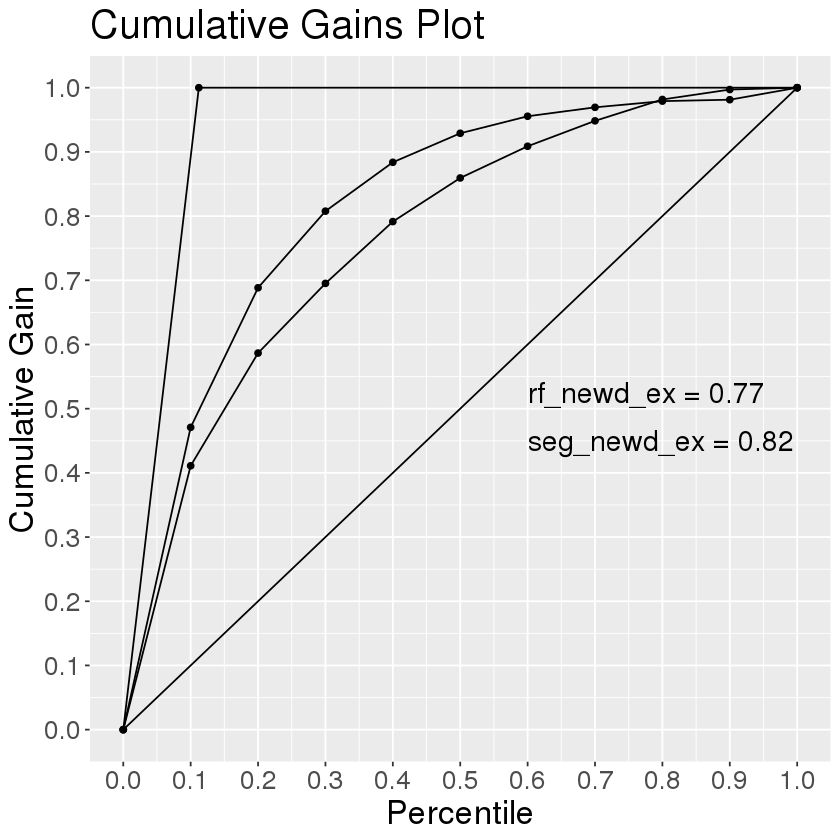

In [105]:
plot_multigains_03_summ4

In [106]:
lift_newdata_df <- cbind(lift_df_seg_glm_expiry_exptest[c("P","lift")],lift_df_ranger_03_expiry[c("lift")])
names(lift_newdata_df) <- c("pct","seg_glm","ranger_03")
lift_newdata_df


pct,seg_glm,ranger_03
<dbl>,<dbl>,<dbl>
0.1,4.708893,4.110477
0.2,3.441723,2.933161
0.3,2.692322,2.317191
0.4,2.209538,1.978549
0.5,1.858000,1.718799
0.6,1.592524,1.514638
0.7,1.384907,1.354815
0.8,1.223854,1.227076
0.9,1.090325,1.107920


# Confusion Matrices

In [42]:
CM_thresh_test <- function (actual, predicted, thresh){
    predicted <- as.factor(predicted>thresh)
    actual <- as.factor(actual=="Renewed")
    confusionMatrix(predicted,actual, positive="TRUE")
}

In [43]:
results5 <- CM_thresh_test(expiry_test_df_1$renewal_status,
                           seg_glm_expiry_exptest$first_renewal_prediction,
                           .5)
cm5 <- as.table(results5)
df5 <- as.matrix(results5, what = "classes")

results6 <- CM_thresh_test(expiry_test_df_1$renewal_status,
                           ranger_predict_03_expiry,
                           .5)
cm6 <- as.table(results6)
df6 <- as.matrix(results6, what = "classes")

In [44]:
perf_newdata_df <- cbind(as.data.frame(df5),as.data.frame(df6))
names(perf_newdata_df) <- c("seg_glm","ranger_03")
perf_newdata_df

,seg_glm,ranger_03
,<dbl>,<dbl>
Sensitivity,0.21578908,0.11743694
Specificity,0.98236089,0.98946010
Pos Pred Value,0.55056926,0.52876803
Neg Pred Value,0.92597832,0.91757633
Precision,0.55056926,0.52876803
Recall,0.21578908,0.11743694
F1,0.31005557,0.19218948
Prevalence,0.09102263,0.09149351
Detection Rate,0.01964169,0.01074472


In [45]:
cm5
cm6

          Reference
Prediction  FALSE   TRUE
     FALSE 263814  21089
     TRUE    4737   5803

          Reference
Prediction  FALSE   TRUE
     FALSE 266800  23966
     TRUE    2842   3189

# Class weighting doesn't work?

In [47]:
library(datasets)

In [48]:
rf <- ranger(Species ~ ., iris, num.trees = 5)
rf_weighted <- ranger(Species ~ ., iris, num.trees = 5, class.weights = c(1, 0, 0))

In [49]:
rf$prediction.error
rf_weighted$prediction.error

[1] 0.07462687

[1] 0.189781

In [62]:

set.seed(123)
tr_idxs <- sample(seq_len(nrow(expiry_train_df_sub)), size = floor(0.05 * nrow(expiry_train_df_sub)))
ts_idxs <- sample(seq_len(nrow(expiry_test_df_sub)), size = floor(0.05 * nrow(expiry_test_df_sub)))

tr <- expiry_train_df_sub[tr_idxs, ] 
ts <- expiry_test_df_sub[ts_idxs, ] 

dim(tr)
dim(ts)

[1] 59412    13

[1] 14839    13

In [51]:
summary(tr$renewal_status)

Not Renewd    Renewed 
     54035       5377

In [83]:
# test_1 <- ranger(
#     formula         = renewal_status ~ ., 
#     data            = tr, 
#     importance = 'impurity', 
#     num.trees       = 100,
# #     class.weights = c(1,10000),
#     probability = TRUE,
#     mtry            = 3,
#     min.node.size   = 10,
#     replace = FALSE,
#     sample.fraction = .8,
#     seed            = 123
# )


# test_2 <- ranger(
#     formula         = renewal_status ~ ., 
#     data            = tr, 
#     importance = 'impurity', 
#     num.trees       = 100,
#     class.weights = c(0,1),
#     probability = TRUE,
#     mtry            = 3,
#     min.node.size   = 10,
#     replace = FALSE,
#     sample.fraction = .8,
#     seed            = 123
# )


# test_3 <- ranger(
#     formula         = renewal_status ~ ., 
#     data            = tr, 
#     importance = 'impurity', 
#     num.trees       = 100,
#     class.weights = c(1,0),
#     probability = TRUE,
#     mtry            = 3,
#     min.node.size   = 10,
#     replace = FALSE,
#     sample.fraction = .8,
#     seed            = 123
# )



test_4 <- ranger(
    formula         = renewal_status ~ ., 
    data            = tr, 
    importance = 'impurity', 
    num.trees       = 100,
    class.weights = c(1,1000),
    probability = TRUE,
    mtry            = 3,
    min.node.size   = 10,
    replace = FALSE,
    sample.fraction = .8,
    seed            = 123
)


In [84]:
test_1$prediction.error
test_2$prediction.error
test_3$prediction.error
test_4$prediction.error
cat("\n")

[1] 0.06556737

[1] 0.06550405

[1] 0.06552138

[1] 0.06550349

In [63]:
# tr$renewal_status <- as.factor(tr$renewal_status)
sapply(tr, class)

renewal_status                  tld            registrar 
            "factor"             "factor"          "character" 
            reseller     reseller_country               region 
         "character"          "character"          "character" 
          reg_period             sld_type           sld_length 
           "integer"             "factor"            "integer" 
         day_domains           gibb_score pattern_domain_count 
           "integer"            "numeric"            "integer" 
            reg_arpt 
           "numeric"

In [56]:
test_21 <- ranger(
    formula         = renewal_status ~ ., 
    data            = tr, 
    importance = 'impurity', 
    num.trees       = 100,
#     class.weights = c(1,10000),
    probability = TRUE,
    mtry            = 3,
    min.node.size   = 10,
    replace = FALSE,
    sample.fraction = .8,
    seed            = 123
)


test_22 <- ranger(
    formula         = renewal_status ~ ., 
    data            = tr, 
    importance = 'impurity', 
    num.trees       = 100,
    class.weights = c(0,1),
    probability = TRUE,
    mtry            = 3,
    min.node.size   = 10,
    replace = FALSE,
    sample.fraction = .8,
    seed            = 123
)


test_23 <- ranger(
    formula         = renewal_status ~ ., 
    data            = tr, 
    importance = 'impurity', 
    num.trees       = 100,
    class.weights = c(1,0),
    probability = TRUE,
    mtry            = 3,
    min.node.size   = 10,
    replace = FALSE,
    sample.fraction = .8,
    seed            = 123
)


# but ultimately, client fills NA's with data from "fallback tables", which would improve performance. asked client for script

In [67]:
# from /scripts/nedata_202005/explore

system("gsutil cp gs://data_input/npv_fallback_tables /home/jupyter/local/Domains_202003/data/npv_fallback_tables")

In [68]:
# npv_fallback_tables	
#   fallback tables where we dont have enough training 
#   data for a particular tld-registrar combination

npv_fallback_names <- load("/home/jupyter/local/Domains_202003/data/npv_fallback_tables")
npv_fallback_names

[1] "npv_fallback_first_final"        "npv_fallback_first_geo_arpt"    
 [3] "npv_fallback_first_geo_arpt_tld" "npv_fallback_first_tld_arpt"    
 [5] "npv_fallback_second_final"       "npv_fallback_second_geo"        
 [7] "npv_fallback_second_tld_geo"     "npv_fallback_third_final"       
 [9] "npv_fallback_third_geo"          "npv_fallback_third_tld_geo"

In [64]:
# [1] "npv_fallback_first_final"        "npv_fallback_first_geo_arpt"    
# [3] "npv_fallback_first_geo_arpt_tld" "npv_fallback_first_tld_arpt"    
# [5] "npv_fallback_second_final"       "npv_fallback_second_geo"        
# [7] "npv_fallback_second_tld_geo"     "npv_fallback_third_final"       
# [9] "npv_fallback_third_geo"          "npv_fallback_third_tld_geo" 

In [69]:
head(npv_fallback_first_final)

region,reg_arpt_slab,expiring_domains,renewed_domains,renewal_rate,index
<chr>,<fct>,<int>,<int>,<dbl>,<chr>
China,"(-Inf,0]",35669,2139,0.060,"China(-Inf,0]"
China,"(0,1]",536645,11052,0.021,"China(0,1]"
China,"(1,3]",84869,12063,0.142,"China(1,3]"
China,"(3,5]",1356,340,0.251,"China(3,5]"
China,"(5,10]",177,36,0.203,"China(5,10]"
China,"(10,15]",427,122,0.286,"China(10,15]"


In [64]:
# Questions:
# not enough training means we also don't have "day_domains"?
# npv_fallback_first_final, _geo_arpt? renewal rate by country & buy price
# npv_fallback_first_final$reg_arpt_slab? reg_arpt: the price at which the domain is bought by the reseller 

# Using a decision tree means you don't need to retrain a model but we can do better than simply using a "fall back table" -- can we confirm this with historical data?

Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '/home/jupyter/local/Domains_202003/data/npv_fallback_tables', probable reason 'No such file or directory'”


ERROR: Error in readChar(con, 5L, useBytes = TRUE): cannot open the connection


# Variable importance

In [38]:
# load("../../data/output/ranger_03_expiry") # new expiry data
load("../../data/ranger_03") # original data

In [47]:
as.data.frame(round(sort(ranger_03_expiry$variable.importance, decreasing=TRUE),0))

,"round(sort(ranger_03_expiry$variable.importance, decreasing = TRUE), 0)"
,<dbl>
reg_arpt,265675
day_domains,120616
gibb_score,99629
sld_length,43497
reseller,26344
registrar,21450
pattern_domain_count,19572
tld,17826
reseller_country,15428


In [46]:
as.data.frame(round(sort(ranger_03$variable.importance, decreasing=TRUE),0))

,"round(sort(ranger_03$variable.importance, decreasing = TRUE), 0)"
,<dbl>
day_domains,92600
gibb_score,86059
sld_length,28108
tld,25682
pattern_domain_count,15233
sld_type,12202
reg_period,10154
registrar,8546
reseller,8537


# Subset where renew_status is not missing

In [31]:
# na_train_df <- expiry_train_df  %>% 
#  summarise_all(~ sum(is.na(.)))  %>% 
#  t()  %>%  as.data.frame()
# na_train_df <- na_train_df[na_train_df$V1>0]
na_train_df

,V1
,<int>
renewal_type,0
renewed_count,0
expiry_date,0
domain_id,0
domain,0
creation_date,0
status,0
tld,0
registrar,0


# Explore renewal type var

In [32]:
expiry_train_df$renewal_type %>% table() %>% prop.table()

.
 FirstTime     Second Subsequent 
0.85217941 0.07805483 0.06976576 

In [34]:
expiry_test_df$renewal_type %>% table() %>% prop.table()

.
 FirstTime     Second Subsequent 
0.85141900 0.07859067 0.06999033 

# Explore autorenew_type as variable

In [35]:
expiry_train_df$autorenew_type %>% table() %>% prop.table()

.
             NULL presumed-realized          realized        unrealized 
     0.0002171294      0.0051060432      0.0811083406      0.9135684868 